In [ ]:
#conda env export > environment.yml

In [92]:
import os
import re
import string
import pandas as pd 
import itertools

## import datasets

In [144]:
# import dataset
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
#target = pd.read_csv('train.csv', usecols=['target'])

In [145]:
print(len(df))
print(len(test_df))

7613
3263


In [146]:
#test_df.drop(['id'], axis=1, inplace=True)
df.drop(['id'], axis=1, inplace=True)

In [147]:
#dups = df[df.duplicated(['text'])]
df.drop_duplicates(subset=['text', 'location', 'keyword'], keep='first', inplace=True)
#test_df.drop_duplicates(subset=['text'], keep='first', inplace=True)

print(len(df))
#print(len(test_df))

7552


## visualize target data

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')

Text(0.5, 1.0, 'Binary Distribution of Disaster Tweet Dataset')

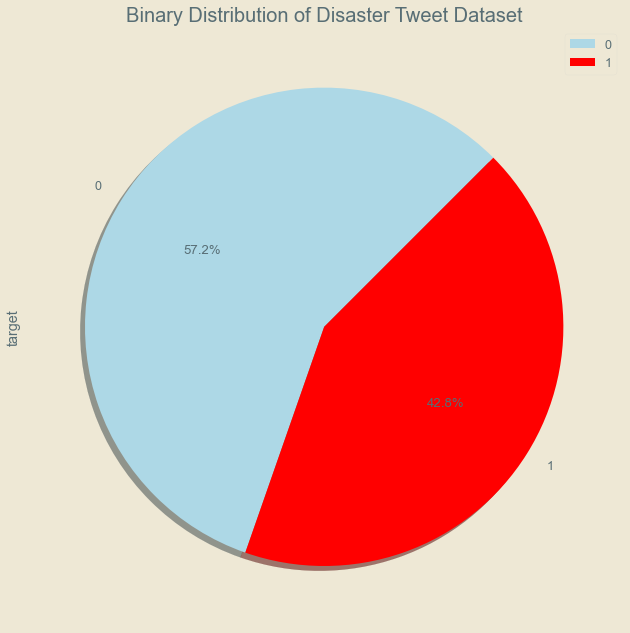

In [136]:
# visualize distribution of target in dataset
plt.figure(figsize=(11,11))
colors = ['lightblue', 'red']
expl = (0, 0.1)
df.target.value_counts().plot(kind='pie', legend=True, startangle=45, shadow=True, 
                             colors=colors, autopct='%1.1f%%')
plt.title('Binary Distribution of Disaster Tweet Dataset', fontsize=20)

# clean and process text

In [137]:
from symspellpy.symspellpy import SymSpell, Verbosity
from spellchecker import SpellChecker
import pkg_resources

## hashtags

In [138]:
# functions related to expanded hashtags in text
def pascal_case_split(text):
    # expand hashtags formatted in pascal case, ex: #ThisIsPascal
    return re.sub(r'([A-Z])([?=a-z0-9+])', r' \1\2', text)

def camel_case_split(text):
    # expand hashtags formatted in pascal case, ex: #thisIsCamel
    return re.sub(r'([a-z0-9+])([?<=A-Z])', r'\1 \2', text)

def spell_check_word(word):
    # lookup suggestions for individual words
    spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=5)
    dictionary_path = pkg_resources.resource_filename(
                      "symspellpy", "frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    corrections = spell.lookup(word, Verbosity.TOP, include_unknown=True)
    closest = corrections[0]
    # display suggestion term, edit distance, and term frequency
    return closest.term
        
def spell_check_words(word):
    # lookup suggestions for multi word string input
    spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=5)
    dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
    bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
    corrections = spell.lookup_compound(word, max_edit_distance=2)
    closest = corrections[0]
# display suggestion term, edit distance, and term frequency
    return closest.term

def desegment_strings(text):
    spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename("symspellpy","frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    if text.isupper() | text.islower() and len(text)>8:
        result = spell.word_segmentation(text)
        text = result.corrected_string
    return text

def remove_hash(text):
    # remove hash symbol in front of hashtag text and remove non unicode chars
    return re.sub('#', '', text)

def expand_strings(text):
    # combine hashtag split functions for specific cases and remove hash
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    h_text = remove_hash(p_text)
    return h_text

def expand_strings_sc(text):
    # combine hashtag split functions for specific cases and remove hash, spell check using compound lookup
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = spell_check_words(p_text)
    h_text = remove_hash(lu_text)
    return h_text

def expand_strings_ds(text):
    # combine hashtag split functions for specific cases and remove hash. spell check using wordsegmentation
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = desegment_strings(p_text)
    h_text = remove_hash(lu_text)
    return h_text

def expand_strings_indv_word(text):
    # combine hashtag split functions for specific cases and remove hash. spell check using wordsegmentation
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = spell_check_word(p_text)
    h_text = remove_hash(lu_text)
    return h_text

# def expand_strings_ds(text):
#     # combine hashtag split functions for specific cases and remove hash
#     c_text = camel_case_split(text)
#     p_text = pascal_case_split(c_text)
#     lu_text = desegment_hashtag(p_text)
#     h_text = remove_hash(lu_text)
#     return h_text

In [11]:
# create column for extracted hashtags
df['hashtags'] = df.text.str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')
test_df['hashtags'] = test_df.text.str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')
df.hashtags = df.hashtags.astype(str)
test_df.hashtags = test_df.hashtags.astype(str)

In [175]:
%time
df['exp_hash'] = df['hashtags'].map(expand_hashtags)

Wall time: 0 ns


In [27]:
df.location.unique()


array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [ ]:
def expand_strings_ds(text):
    # combine hashtag split functions for specific cases and remove hash
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = desegment_strings(p_text)
    h_text = remove_hash(lu_text)
    return h_text

In [ ]:
%time
# with desegment_hashtag
df['exp_hash'] = df['hashtags'].map(expand_hashtags)

# process text

## dictionary based word replacement 

In [101]:
import csv

In [102]:
# import and read previously created dictionary as csv for abbreviations and expansions of words
def csv2dict(csv_name):
    with open(csv_name, mode='r') as f:
        reader = csv.reader(f)
        next(reader)
        return {rows[1]:rows[2] for rows in reader}
location_expansion_dict = csv2dict('utils\location_expansion.csv')
contractions_dict = csv2dict('utils\contractions.csv')

## denoise text

In [103]:
import html

In [104]:
def word_expansion_from_dict(text, expansion_dict):
    c_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
    def replace(match):
        expansion =  f"{expansion_dict[match.group(0)]}"
        return expansion
    text = c_re.sub(replace, text)
    return text

def reduce_repeat_vowels(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    for ch in iter(vowels):
        text = re.sub(r'(?i)'+rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    for ch in iter(consonants):
        text = re.sub(r'(?i)'+ rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text
    
def remove_urls(text):
    # function to remove urls from string
    return re.sub(r"\S*http\S*",  r"", text)

def remove_handles(text):
    # function to remove twitter handles from string
    return re.sub("@\S*",  r" ", text)

def remove_non_uni(text):
    # function to remove non unicode characters from string
    return re.sub('[^\u0000-\u007f]', ' ', text)

def remove_nan_str(text):
    # function to remove 'nan' from string
    return re.sub('nan', '', text)

def remove_ws(text):
    return re.sub(' +', ' ', text)

def remove_non_alpha(text):
    # function to remove non alpha chars from string
    return re.sub("[^a-zA-Z]",  r" ", text)

def denoise_text(text):
    #remove urls
    text = remove_urls(text)
    #remove user handles
    text = remove_handles(text)
    #reduce repeating characters
    text = reduce_repeat_vowels(text)
    text = reduce_repeat_consonants(text)
    #remove xml tag strings
    text = html.unescape(text)
    #remove numeric and punctuation chars
    text = remove_non_alpha(text)
    #remove extra spaces
    text = remove_ws(text)
    return text   
    

## tokenize text

In [105]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

In [106]:
def nltk_tag_to_wordnet_tag(nltk_tag):
# function to convert nltk tag to wordnet tag
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_text(text):
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    # initialize empty list 
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_text.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    return ' '.join(x for x in remove_stopwords(lemmatized_text) if len(x) > 2)


def remove_stopwords(tokens):
    # function to remove stopwords from text
    stop_list = stopwords.words('english')  
    new_tokens = []
    for word in tokens:
        if word not in stop_list:
            new_tokens.append(word)
    return new_tokens


## tweet text process

In [154]:
#### text preprocessing specifically formatted for tweets but will work on any text
def process_tweet(df): 
    """combine regex and nltk processing for tweet text and keyword text processing"""
    def expand_strings_ds(text):
        # combine hashtag split functions for specific cases and remove hash
        c_text = camel_case_split(text)
        p_text = pascal_case_split(c_text)
        lu_text = desegment_strings(p_text)
        h_text = remove_hash(lu_text)
        return h_text
    
    def expand_text(text):
        e_text = expand_strings_ds(text)
        le_text = word_expansion_from_dict(e_text, expansion_dict=location_expansion_dict)
        ce_text = word_expansion_from_dict(le_text.lower(), expansion_dict=contractions_dict)
        return text

    def process_text(text):
        exp_text = expand_text(text)
        clean_text = denoise_text(exp_text)
        lem_text = lemmatize_text(clean_text)
        return lem_text

    processed_df = [process_text(x) for x in df]
    return processed_df

def process_tweet(df): 
    """combine regex and nltk processing for tweet text and keyword text processing"""
    def expand_str(text):
        # combine hashtag split functions for specific cases and remove hash
        c_text = camel_case_split(text)
        p_text = pascal_case_split(c_text)
        lu_text = desegment_hashtags(p_text)
        h_text = remove_hash(p_text)
        return h_text
    
    def expand_words(text):
        e_text = expand_str(text)
        le_text = word_expansion_from_dict(e_text, expansion_dict=location_expansion_dict)
        ce_text = word_expansion_from_dict(le_text.lower(), expansion_dict=contractions_dict)
        return text

    def process_text(text):
        exp_text = expand_words(text)
        clean_text = denoise_text(exp_text)
        #cleaner_text = spell_check_words(clean_text)
        lem_text = lemmatize_text(cleaner_text)
        return lem_text

    processed_df = [process_text(x) for x in df]
    return processed_df

## keyword text process

In [140]:
def process_keyword(df):
    text = df.str.replace('%20', ' ')
    return text

## location text process

In [141]:
def process_location(df):
    """combine regex and nltk processing for location text processing"""
    
    def expand_loc_text(text):
        #exp_text = expand_strings_ds(text) 
        loc_dict_lower = {k.lower(): v for k, v in location_expansion_dict.items()}
        exp_text = word_expansion_from_dict(text.lower(), loc_dict_lower)
        return exp_text 
        
    def process_text(text):
        exp_text = expand_loc_text(text)
        clean_text = denoise_text(exp_text)
        #lem_text = lemmatize_text(clean_text)
        return clean_text
    
    loc_df = [process_text(x) for x in df]
    return loc_df 

# create new dataframe applying above processes

In [155]:
def scrub_data_to_df(df):
    df['tweets'] = process_tweet(df.text)
    df['clean_keyword'] = process_keyword(df.keyword.astype(str))
    df['clean_location'] = process_location(df.location.astype(str))
    return df

In [157]:
scrub_data_to_df(df)

## create column containing combined column text & tokens columns

In [158]:
def combine_columns(df):
    df['clean_keyword'] = df.clean_keyword.astype(str)
    df['clean_keyword'] = df.clean_keyword.str.lower()
    df['clean_keyword'] = df.clean_keyword.str.replace(r'nan', r'')
    df['clean_location'] = df.clean_location.astype(str)
    df['clean_location'] = df.clean_location.str.lower()
    df['clean_location'] = df.clean_location.str.replace(r'nan', r'')
    df['tweets'] = df.tweets.astype(str)
    df['all_text'] = df['tweets'].str.cat(df['clean_location'],sep=" ")
    df['all_text'] = df['all_text'].str.cat(df['clean_keyword'],sep=" ")
    df['all_text'] = df['all_text'].str.strip()
    df['combined_tokens'] = df.all_text.str.lower()
    df['tweet_tokens'] = df.tweets.str.lower()
    df['combined_tokens'] = df.combined_tokens.apply(lambda row: row.split())
    df['tweet_tokens'] = df.tweet_tokens.apply(lambda row: row.split())
    new_df = df.drop(['keyword', 'location', 'text'], axis=1)
    return new_df

In [159]:
train_df = combine_columns(df)
#train_df.drop_duplicates(subset=['tweets'], keep='first', inplace=True)
train_df.to_csv('train_processed.csv')

In [160]:
#test_df2 = combine_columns(test_df)

In [161]:
print(len(train_df))

7552


In [162]:
from collections import Counter
from nltk.probability import FreqDist
from operator import itemgetter

In [163]:
df['b'] = df.text.str.split()
wd = Counter(df.b.sum())

In [164]:
for k,v in wd.items():
    if v == 1:
        
        print (k)

Deeds
ALLAH
Forgive
Ronge
Sask.
'shelter
place'
notified
officers.
13,000
Ruby
pours
=>
directions
#CAfire
Manitou,
woods...
Tampa
hah-
WAIT
SOUTH
TAMPA
FVCK
#raining
#TampaBay
#Tampa
#Flood
#We
multi
man?
fruits
goooooooaaaaaal!!!!!!
ridiculous....
skiing
LOOOOOOL
way...I
week!
Cooool
pasta?
end!
@bbcmtd
http://t.co/lHYXEOHY6C
heavy.
#metal
http://t.co/YAo1e0xngw
#AFRICANBAZE:
news:Nigeria
Aba.
http://t.co/2nndBGwyEi
Crying
SKY
http://t.co/qqsmshaJ3N
@PhDSquares
EPL
Abia
http://t.co/3ImaomknnA
Barbados
#Bridgetown
JAMAICA
ablaze:
Superintende...
http://t.co/wDUEaj8Q4J
out:
http://t.co/rOI2NSmEJJ
http://t.co/3Tj8ZjiN21
http://t.co/YDUiXEfIpE
http://t.co/LxTjc87KLS
visiting
CFC
ancop
ablaze.
Tita
Vida
SOOOO
PUMPED
@southridgelife
preaching...
hotel!
http://t.co/o9qknbfOFX
gained
You?
http://t.co/TIyUliF5c6
http://t.co/vl5TBR3wbr
tracklist
retainers
it;
Brighton
http://t.co/gWNRhMSO8k
http://t.co/eV1ahOUCZA
Superintendent
Lanford
Salmon
http://t.co/vplR5Hka2u
http://t.co/SxHW2TNNLf
Delib

202
4.0
Rl
Boyfriend
Clothes
Sent
@kennethbauer_
noodles
grilled
sandwich.
figured
joked
Wood
innings
#CubsTalk
14028
contained:
http://t.co/LfNIPpNOtO
@thomasvissman22
@KeithyyL
Keithyy
media....
http://t.co/dlkuFtLQnF
oven
fool
coverage
Dat
all-pro
CHICKEN
NUGGETS
MICROWAVE
MINUTES
INTEAD
bike
Sparks
Brush
Brighton:
landowner
cutting
10Û_
http://t.co/rj7m42AtWS
Yall
Bugs
cocoa
sip.
Nap
awesomesauce.
#LetsFootball
SkanndTyagi:
#letsFootball
http://t.co/DmTab6g7j7
501
mandem
totteham
maddddd
ting
dere
@aubilenon
@MarkKriegsman
8-Minute
Fat-Burning
Routine
http://t.co/g2h7xNecD8
#fat
weightless
fatburning
#burnfat
#skinny
#workout
bulletproof
funeral;
cold.
http://t.co/uqssnAAtTu
.@StacDemon
Mullin
JohnÛªs
2015-16:
http://t.co/NmRVTHkvAh
#SJUBB
@JohnsonTionne
Leader
STOP
#Babies
https://t.co/6xYsDN2Xz0
Kanger
coils
/r/Vaping101
http://t.co/cykr4XAlUH
@HuffPostComedy:
attendees
http://t.co/xwVW1sft4I
http://t.co/j7HUKhWmal
visible
Tucson
mountains:
steep
rocky
terrain
mountainsÛ_
http

http://t.co/bQ8Kyi7Gng
http://t.co/GNZwxQktAm
.@unsuckdcmetro
half-derailed
half-railed?
#deepthoughts
Sad
beatdown
pro-democracy
@NYPDnews
undercover:
http://t.co/iHHRKG4V1S.
http://t.co/aryU5qNgJJ
@ItsQueenBaby
india
august
youtube?...
http://t.co/MMIyE1k8ZZ
derailed_benchmark
paths.
resque
too?
@GerryConnolly
@RepDonBeyer
debacle
w/derailed
non-passenger
Rail
MGR
CEO!
@OhYayyyYay
resumed
Garfield
residual
track:
blame?:
Derailment
common.
http://t.co/jdkQC12tid
http://t.co/fcTrAWJcYL
#NDTV
accidentsÛª:
http://t.co/uHXODSc7Wi
#TeamFollowBack
#FollowBack
http://t.co/YvMpHd0z9X
61st
Calumet
2-1-21.
#ChicagoScanner
http://t.co/GieSoMgWTR
Lives:
villagers
passengers'
train...
http://t.co/lTYeFJdM3A
#IndiaTV
http://t.co/0La1aw9uUd
@greateranglia
fault
ALARM/EMS
PLAN
61ST
CALUMET
TRAIN
DERAILMENT
CINS/TG
@Raishimi33
http://t.co/ocxBWGyFT8
http://t.co/iLdbeJe225
@AlvinNelson07
withstand
collisions!
Immediate
derailment.
http://t.co/4Y4YtwhD74
Suresh
Harda
calamity;
ignored:
regr...
http://

Interlocking
Illnesses
Numbers
http://t.co/1uo1aTrbbJ
http://t.co/JwIv6WYW6F
Osage
Cool/Weird
It'll
Skinless
Predator
Arabia:
#Abha:
mosque;
http://t.co/1xW0Z8ZeqW
'Use
wisely
carnage
continuing...let
period..'
#GGIndependencMessage
gross
X-rays
@dwilliams313
@Ieansquad:
http://t.co/NU6wRp716d
-??-
kitana
slay
ÛÓkody?
@KOMBATFANS33)
https://t.co/uMajwSNLUF
OSP
mounting
http://t.co/YmP0gInwza
http://t.co/FYIOQvIOif
X:
Meat
Predator.
https://t.co/IggFNBIxt5
Hiroshima-sized
hometown
http://t.co/BSrERJbY0I
Whitbourne.
allocating
action:
Veneto
http://t.co/w3esX6Ud8t
zero
bite-related
1979.
http://t.co/43sXG9Z6xh
TREMOR
JOKE!!
[TREMOR
DLC]
[FATALITIES/X-RAY]
'Motordom'
lobbied
language
#VisionZero
https://t.co/cAvb7pgEpv
Sharing
cousin's
http://t.co/LSJowGYvQh
'Among
failing
yield
car'
http://t.co/dgUL7FfJt2
SEGA's
http://t.co/fLO8fgy35A
reduces
independent
http://t.co/jVIVT6zrv7
@kevinedwardsjr
http://t.co/NCjLKqASUk
Gameplay
Fatalities/X-Rays
(MKX)
http://t.co/kC8O81BcHG
two-vehicle
Whit

@Colorlines
http://t.co/nLbLtYnV36
http://t.co/bjrrqHHoHL
http://t.co/WUh1g2BLP1
#??_????_?????
#yazidi_shingal_genocide
#EzidiGenocide
mitigating
http://t.co/75VLsw85GI
http://t.co/txY3US2Ejs
Uninvestigated
Years:
Incite
1965
Indonesia
Massacre?
http://t.co/EZbTG81trz
@KabarMesir
@badr58
Crime
RABAA
observed.
#rememberRABAA
@eileenmfl
serious?
Bestie
texas
chainsaw
Petition/No
Medals
1890
Killings
Americans!
http://t.co/UilPg8i1ev
http://t.co/m9pXTo2kwW
massacre!!
Bodies
shells
@Bloodbath_TV
introducing
Nanking
Massacre-4
Eyewitnesses
(English):
http://t.co/TiPnDEmPuz
#Clinton
#Bush
#CBS
#WSJ
#WPO
http://t.co/qw8qk165Sb
Daddy
massacre.
#BeCarefulHarry
Tunisia
http://t.co/kuRqLxFiHL
@CIA
wtf?
@freddiedeboer
@Thucydiplease
Coates
Charleston
broadly
Review:
http://t.co/f0WQlobOoy
BromleyThe
http://t.co/THpBDPdj35
@gigagil
IOF
513
(70%
12)
zionist
morality-zionism
evil!
Sousse
Tunis
http://t.co/MyHHTHsLi3
Soap
Twain
rescind
medals
'honor'
Knee.
RT!
https://t.co/u4r8dRiuAc
@nataliealund
@W

'Ben
favorited'
stressing
stretcher!
Mxaaaa
Africans
Appreciate
#Stretcher
Hating
??#Amazon
#foot
#adjust
#shape
#shoe
Shoe
Shaper
Width
Adjustable
http://t.co/8cPcz2xoHb
Deck
http://t.co/0YO2l38OZr
niqqa
Stretcher-bearers
whose
their...
http://t.co/yeRcT4J244
Scary
Antonio.
floor.
http://t.co/rDxzsL5EAC
http://t.co/QwijRRiYIf
@DareToTaha
foreskin
think?
http://t.co/7qPG80uD7v
1)
'Investigators
early'
SpaceX
Founder
Musk:
Structural
Falcon
http://t.co/LvIzO9CSSR
@lizbon
@KidicalMassDC
breakdown.
patience
http://t.co/Kp1hDchfNZ
Brakes
blamed:
failureÛ_
http://t.co/imAWVMzs3A
http://t.co/FPrt7NwrOt
@SirTitan45
hr
occurs?
correcting
West's
https://t.co/DvieABlOFz
excessive
emerging
defects.
Phew
Examiner
http://t.co/ocMCvfDZkv
[CLIP]
Top-down
coercion
weakness
ensuring
http://t.co/gNORIjnSVa
coÛ_
#preventative
cabling
bracing
trees.
905-877-8591
yours.
#CTS
defects
Galactic's
SpaceshipTwo
http://t.co/EYSbLYX6L6
@KPCC
http://t.co/PnhPLJHo8E
http://t.co/AdZ8kbuRt7
http://t.co/WC69XAJIs4
@

In [165]:
len(wd)

31924

In [166]:
word_dict = Counter(df.tweet_tokens.sum())
word_dict

Counter({'our': 27,
         'deeds': 2,
         'reason': 27,
         'earthquake': 50,
         'may': 87,
         'allah': 9,
         'forgive': 3,
         'forest': 66,
         'fire': 347,
         'near': 56,
         'ronge': 1,
         'sask': 1,
         'canada': 13,
         'all': 70,
         'resident': 5,
         'ask': 25,
         'shelter': 7,
         'place': 33,
         'notify': 1,
         'officer': 38,
         'evacuation': 52,
         'order': 41,
         'expect': 32,
         'people': 197,
         'receive': 4,
         'wildfire': 78,
         'california': 121,
         'just': 56,
         'get': 423,
         'send': 48,
         'photo': 47,
         'ruby': 1,
         'alaska': 7,
         'smoke': 52,
         'pour': 3,
         'school': 68,
         'rockyfire': 4,
         'update': 50,
         'hwy': 11,
         'close': 35,
         'direction': 15,
         'due': 31,
         'lake': 16,
         'county': 38,
         'cafire

In [167]:
num_words = sum(word_dict[w] for w in word_dict)
print(f'There are {num_words} words in the entire training dataset')

There are 65654 words in the entire training dataset


In [168]:
word_count_sorted = [(value, key) for key, value in word_dict.items()]
word_count_sorted.sort()
print(f'There are {len(word_count_sorted)} unique words in the training dataset')

There are 12471 unique words in the training dataset


In [169]:
mono_use = []
for k,v in word_dict.items():
    if v == 1:
        mono_use.append(k)
print (mono_use)

['ronge', 'sask', 'notify', 'ruby', 'manitou', 'fvck', 'tampabay', 'skiing', 'africanbaze', 'crying', 'epl', 'barbados', 'bridgetown', 'superintende', 'ancop', 'pumped', 'preach', 'tracklist', 'retainer', 'superintendent', 'lanford', 'deliberately', 'noches', 'bestia', 'teammate', 'goodnight', 'gunner', 'kurds', 'trample', 'vandalized', 'diyala', 'voortrekker', 'tambo', 'intl', 'revel', 'farewell', 'gtxrwm', 'greeting', 'pen', 'publications', 'jacinta', 'mar', 'tinderbox', 'testicle', 'nashvilletraffic', 'santaclara', 'bayarea', 'personalinjury', 'otleyhour', 'stlouis', 'caraccidentlawyer', 'speeding', 'accidents', 'curry', 'herman', 'stephenson', 'overturned', 'bigrigradio', 'ramp', 'cabrillo', 'magellan', 'mir', 'congestion', 'pastor', 'spilt', 'mayonnaise', 'pissed', 'donnie', 'truckcrash', 'overturns', 'fortworth', 'ashville', 'crossed', 'median', 'naayf', 'chandanee', 'magu', 'halfway', 'conf', 'eddy', 'wpd', 'willis', 'foreman', 'aashiqui', 'anu', 'aggarwal', 'suffield', 'lanes',

In [170]:
corpus = list(word_dict.keys())

corpus_frequency = FreqDist(corpus)

corpus_common=corpus_frequency.most_common()

In [171]:
corpus_common

[('our', 1),
 ('deeds', 1),
 ('reason', 1),
 ('earthquake', 1),
 ('may', 1),
 ('allah', 1),
 ('forgive', 1),
 ('forest', 1),
 ('fire', 1),
 ('near', 1),
 ('ronge', 1),
 ('sask', 1),
 ('canada', 1),
 ('all', 1),
 ('resident', 1),
 ('ask', 1),
 ('shelter', 1),
 ('place', 1),
 ('notify', 1),
 ('officer', 1),
 ('evacuation', 1),
 ('order', 1),
 ('expect', 1),
 ('people', 1),
 ('receive', 1),
 ('wildfire', 1),
 ('california', 1),
 ('just', 1),
 ('get', 1),
 ('send', 1),
 ('photo', 1),
 ('ruby', 1),
 ('alaska', 1),
 ('smoke', 1),
 ('pour', 1),
 ('school', 1),
 ('rockyfire', 1),
 ('update', 1),
 ('hwy', 1),
 ('close', 1),
 ('direction', 1),
 ('due', 1),
 ('lake', 1),
 ('county', 1),
 ('cafire', 1),
 ('flood', 1),
 ('disaster', 1),
 ('heavy', 1),
 ('rain', 1),
 ('cause', 1),
 ('flash', 1),
 ('flooding', 1),
 ('street', 1),
 ('manitou', 1),
 ('colorado', 1),
 ('springs', 1),
 ('area', 1),
 ('top', 1),
 ('hill', 1),
 ('see', 1),
 ('wood', 1),
 ('there', 1),
 ('emergency', 1),
 ('happen', 1),
 ('

In [53]:
remove_words = [k for k,v in word_dict.items() if int(v) == 1]


In [55]:
te = [x for x in remove_words if len(x)>7]
te

['breaking',
 'africanbaze',
 'imaomknn',
 'barbados',
 'bridgetown',
 'superintende',
 'tracklist',
 'retainer',
 'superintendent',
 'deliberately',
 'teammate',
 'goodnight',
 'vandalized',
 'voortrekker',
 'farewell',
 'greeting',
 'publication',
 'tinderbox',
 'testicle',
 'personalinjury',
 'caraccidentlawyer',
 'stephenson',
 'overturned',
 'cabrillo',
 'magellan',
 'congestion',
 'mayonnaise',
 'ashville',
 'chandanee',
 'aashiqui',
 'aggarwal',
 'suffield',
 'langtree',
 'alternate',
 'financially',
 'hagerstown',
 'disciplinary',
 'bannister',
 'eisenhower',
 'remembers',
 'terrifying',
 'disclaimer',
 'lifehacks',
 'wiedemer',
 'silverwood',
 'biblestudy',
 'interrupt',
 'carnegie',
 'sandscrims',
 'mbataweel',
 'binladen',
 'unbelievably',
 'aeroplane',
 'naturally',
 'fletcher',
 'statistically',
 'aberystwyth',
 'shrewsbury',
 'nanotech',
 'justsaying',
 'randomthought',
 'nissonian',
 'hatzolah',
 'standardise',
 'clinical',
 'cleanest',
 'muschamp',
 'careworn',
 'entire

In [54]:
remove_words

['ronge',
 'sask',
 'notify',
 'afire',
 'manitou',
 'fvck',
 'breaking',
 'skiing',
 'hyxeoh',
 'xngw',
 'africanbaze',
 'epl',
 'imaomknn',
 'barbados',
 'bridgetown',
 'superintende',
 'eaj',
 'zji',
 'tjc',
 'kls',
 'ancop',
 'vida',
 'pumped',
 'preach',
 'ofx',
 'uli',
 'wbr',
 'tracklist',
 'retainer',
 'oucza',
 'superintendent',
 'lanford',
 'deliberately',
 'xarb',
 'noches',
 'bestia',
 'teammate',
 'goodnight',
 'trample',
 'vandalized',
 'diyala',
 'voortrekker',
 'tambo',
 'intl',
 'revel',
 'farewell',
 'gtx',
 'greeting',
 'pen',
 'publication',
 'jacinta',
 'mar',
 'navista',
 'tinderbox',
 'sjf',
 'ftc',
 'fvnxer',
 'testicle',
 'clara',
 'rwr',
 'personalinjury',
 'otley',
 'stlouis',
 'caraccidentlawyer',
 'curry',
 'herman',
 'stephenson',
 'overturned',
 'ramp',
 'junky',
 'ysxun',
 'ceh',
 'cabrillo',
 'magellan',
 'mir',
 'congestion',
 'spilt',
 'mayonnaise',
 'pissed',
 'donnie',
 'ashville',
 'median',
 'rlmy',
 'chandanee',
 'magu',
 'halfway',
 'turned',
 '

In [ ]:
test_df[test_df['text'].str.contains("#")]

In [ ]:
train_df[train_df['tweets'].str.contains("&")]


In [115]:
df.loc[df['location'].str.contains("#")]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [117]:
print(df.location.unique())

[nan 'Birmingham' 'Est. September 2012 - Bristol' ... 'Vancouver, Canada'
 'London ' 'Lincoln']
